<a href="https://colab.research.google.com/github/patricksabry/UTS_ML2019_ID98106545/blob/master/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Recommendation System using Spark (PySpark)

The following notebook outlines the implementation of a content based recommendation system using Apache Spark. Spark will be used for scalable parallel memory-based data processing. This will ensure that this algorithm implementation is highly scalable based on how large of a compute cluster it is run on. Spark's ML library will be accessed via PySpark, Spark's high level Python API.

The dataset used for the recommendation system will be the open sourced MovieLens dataset. Movies will be recommended based on collaborative filtering using an Alternate Least Squares algorithm to find similar user ratings for certain movies.

$\hat{r}$ = $\sum_{f=0}^{n factors}$ $H_{u,f}$$W_{f,i}$

Whereby for any item $i$ given by user $u$ the rating of the item can be expressed as a matrix dot ptoduct of the user latent vector $H$ and the item latent vector $W$.

## Loading the dataset & exploration



In [19]:
from google.colab import files
import io
import pandas as pd

movies_url = 'https://raw.githubusercontent.com/patricksabry/UTS_ML2019_ID98106545/master/movies.csv'
ratings_url = 'https://raw.githubusercontent.com/patricksabry/UTS_ML2019_ID98106545/master/ratings.csv'
df_movies = pd.read_csv(movies_url)
df_ratings = pd.read_csv(ratings_url)

print(df_movies.head())
print(df_ratings.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [35]:
df = pd.merge(df_ratings, df_movies, on='movieId')
print(df.head())
df.shape

   userId  ...                                       genres
0       1  ...  Adventure|Animation|Children|Comedy|Fantasy
1       5  ...  Adventure|Animation|Children|Comedy|Fantasy
2       7  ...  Adventure|Animation|Children|Comedy|Fantasy
3      15  ...  Adventure|Animation|Children|Comedy|Fantasy
4      17  ...  Adventure|Animation|Children|Comedy|Fantasy

[5 rows x 6 columns]


(100836, 6)

In [31]:
num_ratings = df.rating.count()
num_movies = df['movieId'].nunique()
num_users = df['userId'].nunique()

print("Observed " + str(num_ratings) + " ratings from " + str(num_users) + " users on " + str(num_movies) + " movies")

Observed 100836 ratings from 610 users on 9724 movies


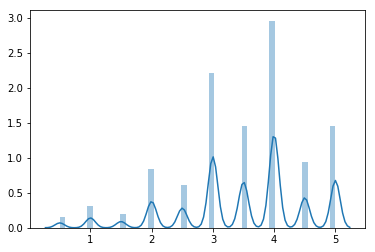

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

x = df['rating'].values
sns.distplot(x)
plt.show()

## function to compute RMSE for ALS algorithm

RMSE will be used as an error measure between predictions and base truth ratings. The aim of the ALS algorithm is to minimise the RMSE between the val/test datasets.

In [0]:
def compute_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Train / Val / Test split

## Downloading Spark dependencies & initializing enviornment


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql import SQLContext

In [88]:
from pyspark.ml.recommendation import ALS
spark_df = sc.createDataFrame(df)
spark_df.show(n=5)

X_train, X_test = spark_df.randomSplit([0.7,0.3])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(X_train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(X_test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
userRecs.show(10,False)
movieRecs.show(10,False)

sc.stop()

+------+-------+------+----------+----------------+--------------------+
|userId|movieId|rating| timestamp|           title|              genres|
+------+-------+------+----------+----------------+--------------------+
|     1|      1|   4.0| 964982703|Toy Story (1995)|Adventure|Animati...|
|     5|      1|   4.0| 847434962|Toy Story (1995)|Adventure|Animati...|
|     7|      1|   4.5|1106635946|Toy Story (1995)|Adventure|Animati...|
|    15|      1|   2.5|1510577970|Toy Story (1995)|Adventure|Animati...|
|    17|      1|   4.5|1305696483|Toy Story (1995)|Adventure|Animati...|
+------+-------+------+----------+----------------+--------------------+
only showing top 5 rows

Root-mean-square error = 1.1171690529618739
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                         